# Diabetic Retinopathy 

Diabetic retinopathy (DR), also known as diabetic eye disease, is a medical condition in which damage occurs to the retina due to diabetes mellitus. It is a leading cause of blindness. Diabetic retinopathy affects up to 80 percent of those who have had diabetes for 20 years or more. Diabetic retinopathy often has no early warning signs. **Retinal (fundus) photography with manual interpretation is a widely accepted screening tool for diabetic retinopathy**, with performance that can exceed that of in-person dilated eye examinations. 

The below figure shows an example of a healthy patient and a patient with diabetic retinopathy as viewed by fundus photography ([source](https://www.biorxiv.org/content/biorxiv/early/2018/06/19/225508.full.pdf)):

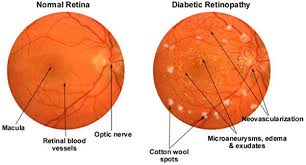

An automated tool for grading severity of diabetic retinopathy would be very useful for accerelating detection and treatment. Recently, there have been a number of attempts to utilize deep learning to diagnose DR and automatically grade diabetic retinopathy. This includes this [competition](https://kaggle.com/c/diabetic-retinopathy-detection) and [work by Google](https://ai.googleblog.com/2016/11/deep-learning-for-detection-of-diabetic.html). Even one deep-learning based system is [FDA approved](https://www.fda.gov/NewsEvents/Newsroom/PressAnnouncements/ucm604357.htm). 

Clearly, this dataset and deep learning problem is quite well-characterized. 

# A look at the data:

Data description from the competition:

>You are provided with a large set of high-resolution retina images taken under a variety of imaging conditions. A left and right field is provided for every subject. >Images are labeled with a subject id as well as either left or right (e.g. 1_left.jpeg is the left eye of patient id 1).
>
>A clinician has rated the presence of diabetic retinopathy in each image on a scale of 0 to 4, according to the following scale:
>
>0 - No DR
>
>1 - Mild
>
>2 - Moderate
>
>3 - Severe
>
>4 - Proliferative DR
>
>Your task is to create an automated analysis system capable of assigning a score based on this scale.

...

> Like any real-world data set, you will encounter noise in both the images and labels. Images may contain artifacts, be out of focus, underexposed, or overexposed. A major aim of this competition is to develop robust algorithms that can function in the presence of noise and variation.

For a simpler project, I will perform binary classification of Referrable Diabetic Retinopathy (RDR), which are cases with stage 2 or above. This sort of classification has been done in previous research, including Google's research paper as mentioned above.


In [1]:
import os
files = os.listdir('../input/resized_train/resized_train')
print(len(files)) 

35126


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai import *
from fastai.vision import *
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
print('Make sure cuda is installed:', torch.cuda.is_available())
print('Make sure cudnn is enabled:', torch.backends.cudnn.enabled)

Make sure cuda is installed: True
Make sure cudnn is enabled: True


# Reading data
Here I am going to open the dataset with pandas, check distribution of labels, and oversample to reduce imbalance.

In [5]:
base_image_dir = os.path.join('..', 'input')
df = pd.read_csv(os.path.join(base_image_dir, 'trainLabels_cropped.csv'))
df['path'] = df['image'].map(lambda x: os.path.join(base_image_dir,'resized_train_cropped/resized_train_cropped','{}.jpeg'.format(x)))
df = df.drop(columns=['image'])
df = df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
df['level'] = (df['level'] > 1).astype(int) # Disease or no disease
df.head(10)

,Unnamed: 0,Unnamed: 0.1,level,path
0,33295,33311,0,../input/resized_train_cropped/resized_train_c...
1,29603,29619,0,../input/resized_train_cropped/resized_train_c...
2,23031,23045,0,../input/resized_train_cropped/resized_train_c...
3,20144,20156,1,../input/resized_train_cropped/resized_train_c...
4,13307,13316,1,../input/resized_train_cropped/resized_train_c...
5,15926,15936,0,../input/resized_train_cropped/resized_train_c...
6,6862,6866,0,../input/resized_train_cropped/resized_train_c...
7,27495,27511,0,../input/resized_train_cropped/resized_train_c...
8,34018,34035,0,../input/resized_train_cropped/resized_train_c...
9,15242,15252,0,../input/resized_train_cropped/resized_train_c...


The dataset is highly imbalanced, with many samples with no disease:

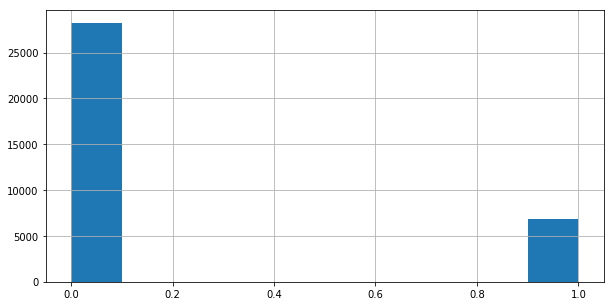

In [6]:
df['level'].hist(figsize = (10, 5))

In [7]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df,test_size=0.2) # Here we will perform an 80%/20% split of the dataset, with stratification to keep similar distribution in validation set

7022

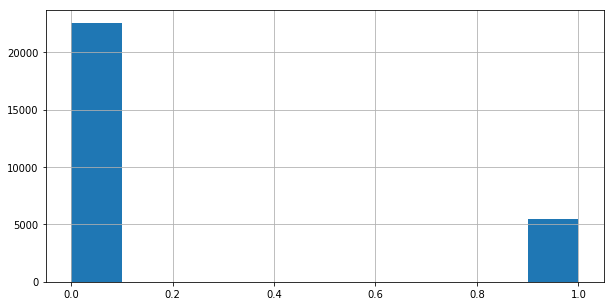

In [8]:
train_df['level'].hist(figsize = (10, 5))
len(val_df)

In [9]:
df = pd.concat([train_df,val_df]) #beginning of this dataframe is the training set, end is the validation set
len(df)

35108

In [10]:
bs =16 #smaller batch size is better for training, but may take longer
sz=512

Here, I load the dataset into the `ImageItemList` class provided by `fastai`. The fastai library also implements various transforms for data augmentation to improve training. While there are some defaults that I leave intact, I add vertical flipping (`do_flip=True`) as this has been commonly used for this particular problem.

Typically, one would use the `ImageDataBunch` class to load the dataset much easier, but as I will adjust the splitting and add oversampling in future kernels, I have used this customized creation of the DataBunch using the `data_block` API.

In [11]:
tfms = get_transforms(do_flip=True,flip_vert=True,max_rotate=None,max_warp=0,max_zoom=1.0,max_lighting=0.1,p_lighting=0.5)
src = (ImageList.from_df(df=df,path='./',cols='path') #get dataset from dataset
        .split_by_idx(range(len(train_df)-1,len(df))) #Splitting the dataset
        .label_from_df(cols='level') #obtain labels from the level column
      )
data= (src.transform(tfms,size=sz,resize_method=ResizeMethod.SQUISH) #Data augmentation
        .databunch(bs=bs,num_workers=4) #DataBunch
        .normalize(imagenet_stats) #Normalize     
       )

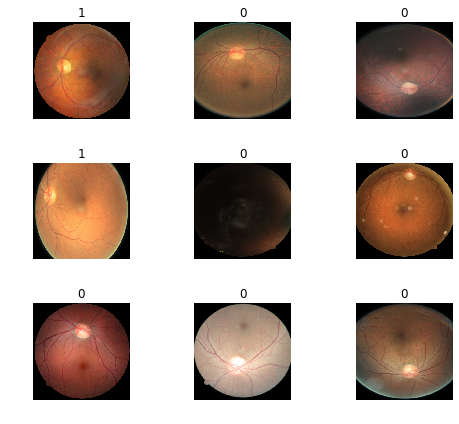

In [12]:
data.show_batch(rows=3, figsize=(7,6))

In [13]:
print(data.classes)
len(data.classes),data.c

[0, 1]


(2, 2)

# Training (Transfer learning) 

**Training:**

We use transfer learning, where we retrain the last layers of a pretrained neural network. I use the ResNet50 architecture trained on the ImageNet dataset, which has been commonly used for pre-training applications in computer vision. Fastai makes it quite simple to create a model and train:

In [14]:
import torchvision
from fastai.metrics import *
from fastai.callbacks import *
learn = cnn_learner(data, models.squeezenet1_1, wd = 1e-5, metrics = [accuracy,AUROC()],callback_fns=[partial(CSVLogger,append=True)])

Downloading: "https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth" to /tmp/.torch/models/squeezenet1_1-f364aa15.pth
4966400it [00:00, 11357868.13it/s]


We use the learning-rate finder developed by Dr. Leslie Smith and implemented by the fastai team in their library:

In [15]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.75E-06


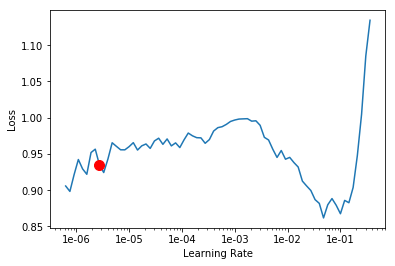

In [16]:
learn.recorder.plot(suggestion=True)

Here we can see that the loss decreases fastest around `lr=1e-2` so that is what we will use to train: 

In [17]:
learn.fit_one_cycle(1,max_lr = 1e-2)

epoch,train_loss,valid_loss,accuracy,auroc,time
0,0.425735,0.412875,0.841378,0.809488,28:27


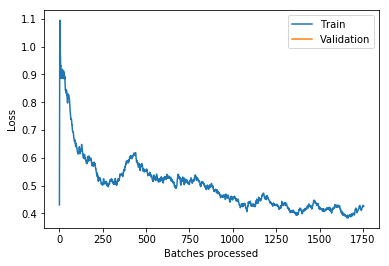

In [18]:
learn.recorder.plot_losses()

In [19]:
learn.save('stage-1-512')

The previous model only trained the last model. We can unfreeze the rest of the model, and train the rest of the model using discriminative learning rates. The first layers aren't changed as much, with lower learning rates, while the last layers are changed more, with higher learning rates. We use the learning rate finder again, and use a range of learning rates for different layers in the neural network.

In [20]:
learn.load('stage-1-512')

Learner(data=ImageDataBunch;

Train: LabelList (28085 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
1,0,0,0,0
Path: .;

Valid: LabelList (7023 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
0,1,0,0,1
Path: .;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
      (1): ReLU(inplace)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
      (3): Fire(
        (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
        (squeeze_activation): ReLU(inplace)
        (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
        (expand1x1_activation): ReLU(inplace)
        (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (expand3x3_activation): ReLU(

In [21]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


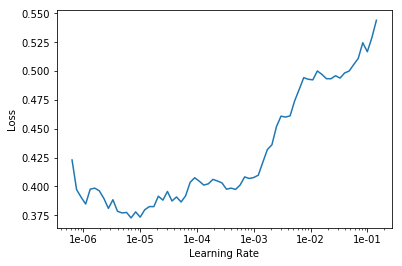

In [22]:
learn.lr_find()
learn.recorder.plot()

In [23]:
learn.fit_one_cycle(16, max_lr=slice(1e-6,1e-2),callbacks=[SaveModelCallback(learn, every='epoch')])

epoch,train_loss,valid_loss,accuracy,auroc,time
0,0.390194,0.452819,0.856472,0.842951,27:27


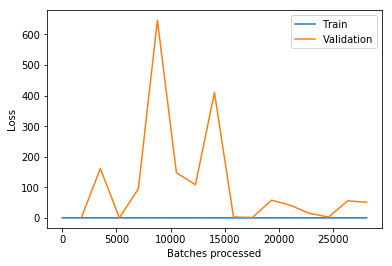

In [24]:
learn.recorder.plot_losses()

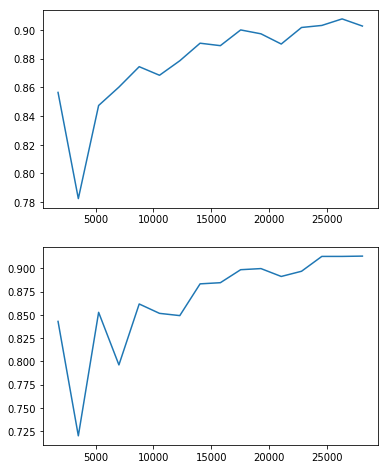

In [25]:
learn.recorder.plot_metrics()

In [26]:
learn.save('stage-2-512')

# Checking results

We look at our predictions and make a confusion matrix.

In [27]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

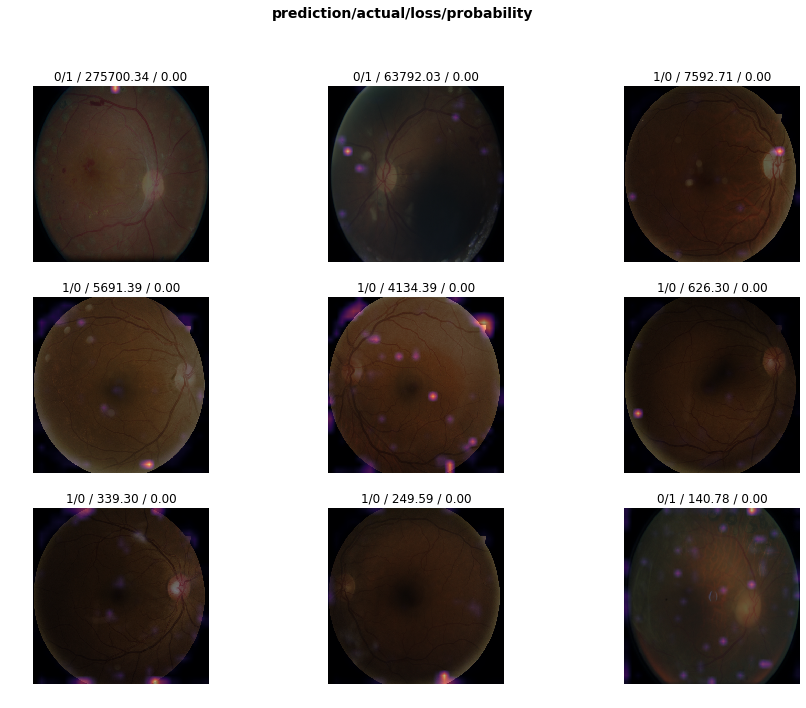

In [28]:
interp.plot_top_losses(9, figsize=(15,11))

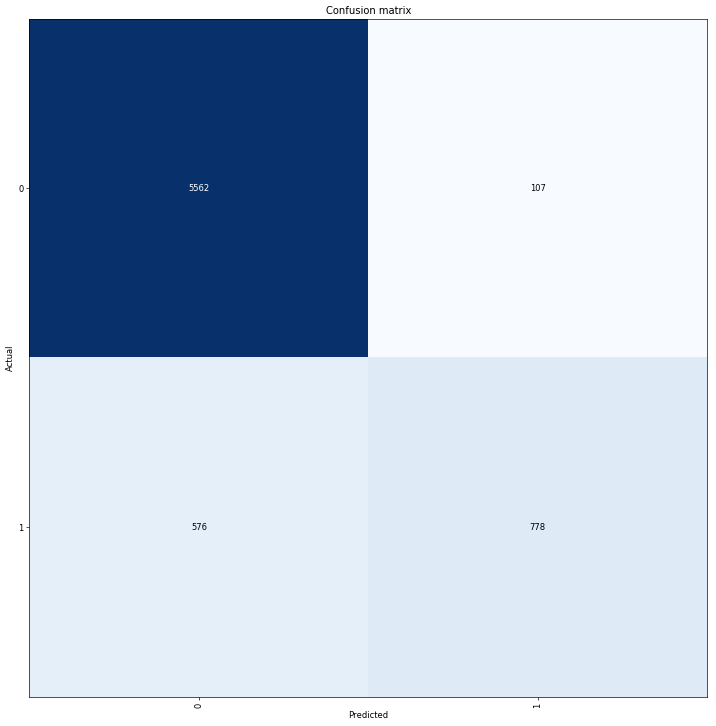

In [29]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [30]:
from sklearn.metrics import roc_auc_score, recall_score
def auc_score(y_score,y_true):
    try:
      auc = torch.tensor(roc_auc_score(y_true,y_score[:,1]))
    except:
      auc = torch.tensor(np.nan)
    return auc

probs,val_labels = learn.get_preds(ds_type=DatasetType.Valid) 
print('Accuracy',accuracy(probs,val_labels)),
print('Error Rate', error_rate(probs, val_labels))
print('AUC', auc_score(probs,val_labels))
print('Specificity and Sensitivity',recall_score(val_labels,probs[:,0]>0.5),recall_score(val_labels,probs[:,1]>0.5))

Accuracy tensor(0.9027)
Error Rate tensor(0.0973)
AUC tensor(0.9131)
Specificity and Sensitivity 0.4254062038404727 0.5745937961595273


Our model has decent AUC (around 0.90), which is similar to some of the [results](https://arxiv.org/abs/1803.04337) demonstrated previously. However, this is still not close to AUC=0.99 demonstrated by Google.

We can use an optimized threshold as well:

In [31]:
from sklearn.metrics import roc_curve
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value

    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 
  

print(probs[:,1]) 
from sklearn.metrics import confusion_matrix

threshold = Find_Optimal_Cutoff(val_labels,probs[:,1])
print(threshold)

print(confusion_matrix(val_labels,probs[:,1]>threshold[0]))

tensor([0.2200, 0.9041, 0.0199,  ..., 0.0917, 0.5998, 0.8309])
[0.1384756714105606]
[[4754  915]
 [ 219 1135]]


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [32]:
learn.export()